# NHL Hockey Analysis

#### Model Goal: Determining game outcomes based on non-goal metrics

![image.png](https://thesportsdailydigital.files.wordpress.com/2018/07/hb740lltkxmz1.png?w=2000&h=1200&crop=1)

![image.jpg](https://nhl.bamcontent.com/images/photos/289358084/1536x864/cut.jpg)

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from plotnine import *

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

sns.set_style('darkgrid')

%matplotlib inline

import warnings

warnings.simplefilter("ignore", UserWarning)

In [2]:
import graphviz
from sklearn.tree import export_graphviz
from sklearn.datasets import *
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
! conda install -y -c anaconda graphviz

Solving environment: done

# All requested packages already installed.



### Import & Clean Data

![image.png](table_relationships.JPG)

In [3]:
# player_info = pd.read_csv('./nhl-game-data/player_info.csv')
# game_goalie_stats = pd.read_csv('./nhl-game-data/game_goalie_stats.csv')
# game_plays = pd.read_csv('./nhl-game-data/game_plays.csv')
# game_plays_players = pd.read_csv('./nhl-game-data/game_plays_players.csv')
# game_shifts = pd.read_csv('./nhl-game-data/game_shifts.csv')
# game_skater_stats = pd.read_csv('./nhl-game-data/game_skater_stats.csv')

In [4]:
game = pd.read_csv('./nhl-game-data/game.csv')
game_team_stats = pd.read_csv('./nhl-game-data/game_teams_stats.csv')
team_info = pd.read_csv('./nhl-game-data/team_info.csv')

In [5]:
df_temp = pd.merge(team_info[['team_id','franchiseId', 
                                'shortName', 'teamName', 'abbreviation']],
              game_team_stats, 
              on=['team_id']
             )
df = pd.merge(game[['game_id','season','type',
                          'date_time','away_team_id','home_team_id',
                          'away_goals','home_goals']],
                df_temp,
                   on=['game_id']
                   )

In [6]:
# Convert date_time to date/time format, create 'year' column
df['date_time'] = pd.to_datetime(df['date_time'])
df['year'] = df['date_time'].dt.year.astype(str)

In [7]:
# Remove playoff games, as well as abbreviated 2012 - 2013 season
df = df[~df.type.str.contains("P")]
df = df.loc[~(df['season'] == 20122013)]

In [8]:
# Create two different data sets to create unique data value set for home & away team
df.sort_values(by=['HoA'], inplace=True)
df_home = df.drop_duplicates(subset=['game_id'], keep='last')
df_away = df.drop_duplicates(subset=['game_id'], keep='first')

In [9]:
# Inner join home & away data sets to merge data sets and prepare for exploratory analysis
df = pd.merge(df_home, df_away, on='game_id', how='inner',suffixes=('_home','_away'))
print('Number of games:',len(df))

Number of games: 6191


In [10]:
# df['pim_opp_home'] = (df['pim_away'] / df['powerPlayOpportunities_home'])
# df['pim_opp_away'] = (df['pim_home'] / df['powerPlayOpportunities_away'])

In [11]:
# In order to link home team & away team statistics, we have combined our fourteen variables 
## to create seven keystone variables: powerPlayOpps, PIMs, Shots, Hits, Face Off Win %, Giveaways, Takeaways.
df['goal_diff'] = df['home_goals_home'] - df['away_goals_away']
df['powerPlayOpportunities_diff'] = df['powerPlayOpportunities_home'] - df['powerPlayOpportunities_away']
df['pim_diff'] = df['pim_home'] - df['pim_away']
df['shots_diff'] = df['shots_home'] - df['shots_away']
df['hits_diff'] = df['hits_home'] - df['hits_away']
df['faceOffWinPercentage_diff'] = df['faceOffWinPercentage_home'] - df['faceOffWinPercentage_away']
df['giveaways_diff'] = df['giveaways_home'] - df['giveaways_away']
df['takeaways_diff'] = df['takeaways_home'] - df['takeaways_away']

### Exploratory Data Analysis

% of home team wins
True     54.6
False    45.4
Name: won_home, dtype: float64


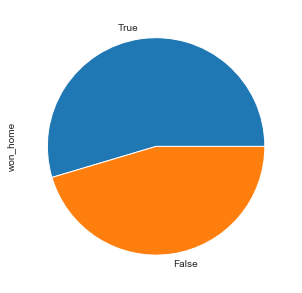

In [12]:
df['won_home'].value_counts(normalize=True).mul(100).plot(kind='pie',
    figsize=(10,5), sort_columns=False)
print('% of home team wins')
print(df['won_home'].value_counts(normalize=True).mul(100).round(1))

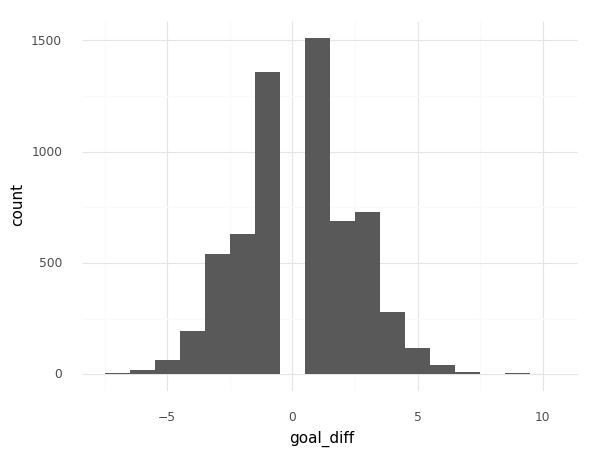

<ggplot: (-9223372036556150240)>

In [14]:
goal_differential = df
(
    
ggplot(goal_differential, 
       aes(x='goal_diff',fill='goal_diff')
      )
 + geom_histogram(binwidth=1)
 + theme_minimal()
)

{'whiskers': [<matplotlib.lines.Line2D at 0x11cd06240>,
 'caps': [<matplotlib.lines.Line2D at 0x11cd06940>,
 'boxes': [<matplotlib.lines.Line2D at 0x11cd060b8>],
 'medians': [<matplotlib.lines.Line2D at 0x11dc86080>],
 'fliers': [<matplotlib.lines.Line2D at 0x11dc86400>],
 'means': []}

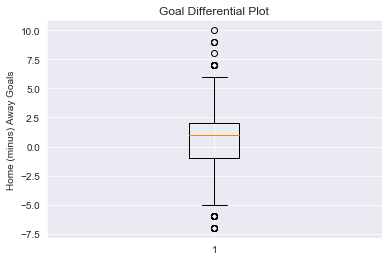

In [15]:
plt.title('Goal Differential Plot')
plt.ylabel('Home (minus) Away Goals')
plt.boxplot(list(df.goal_diff))

Text(0, 0.5, 'home vs. away')

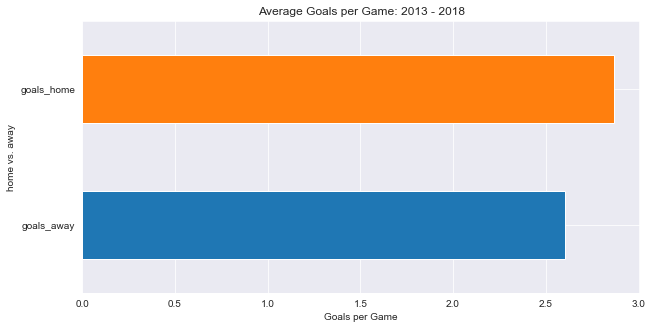

In [16]:
df[['goals_home','goals_away']].mean().sort_values().plot(kind='barh',figsize=(10,5))
plt.title('Average Goals per Game: 2013 - 2018')
plt.xlabel('Goals per Game')
plt.ylabel('home vs. away')

Text(0, 0.5, 'home vs. away')

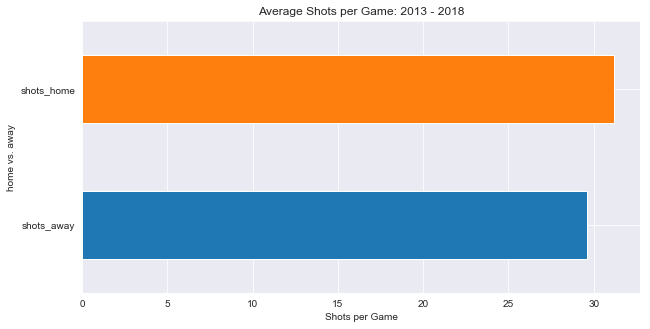

In [17]:
df[['shots_home','shots_away']].mean().sort_values().plot(kind='barh',figsize=(10,5))
plt.title('Average Shots per Game: 2013 - 2018')
plt.xlabel('Shots per Game')
plt.ylabel('home vs. away')

Text(0, 0.5, 'home vs. away')

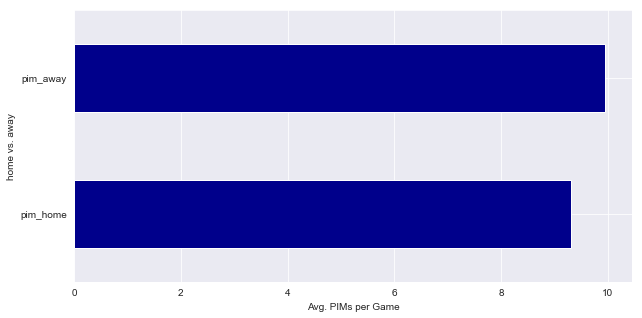

In [18]:
df[['pim_home','pim_away']].mean().plot(kind='barh',figsize=(10,5),color='darkblue')
plt.xlabel('Avg. PIMs per Game')
plt.ylabel('home vs. away')

Text(0, 0.5, 'Giveaways & Takeaways')

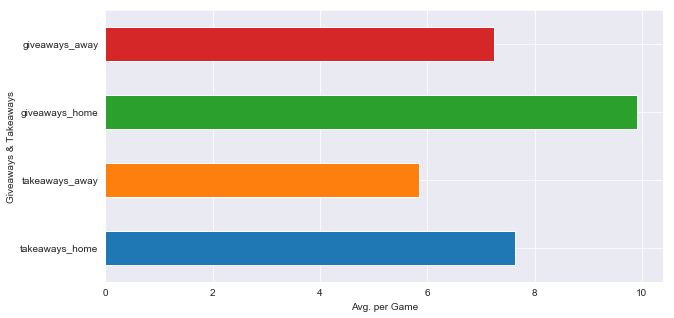

In [19]:
df[['takeaways_home','takeaways_away','giveaways_home','giveaways_away']].mean().plot(kind='barh',figsize=(10,5))
plt.xlabel('Avg. per Game')
plt.ylabel('Giveaways & Takeaways')

In [20]:
grouped = df.groupby(['season_home','won_home']).count().reset_index()

In [21]:
grouped.head()

,season_home,won_home,game_id,type_home,date_time_home,away_team_id_home,home_team_id_home,away_goals_home,home_goals_home,team_id_home,...,takeaways_away,year_away,goal_diff,powerPlayOpportunities_diff,pim_diff,shots_diff,hits_diff,faceOffWinPercentage_diff,giveaways_diff,takeaways_diff
0,20132014,False,570,570,570,570,570,570,570,570,...,570,570,570,570,570,570,570,570,570,570
1,20132014,True,660,660,660,660,660,660,660,660,...,660,660,660,660,660,660,660,660,660,660
2,20142015,False,564,564,564,564,564,564,564,564,...,564,564,564,564,564,564,564,564,564,564
3,20142015,True,666,666,666,666,666,666,666,666,...,666,666,666,666,666,666,666,666,666,666
4,20152016,False,579,579,579,579,579,579,579,579,...,579,579,579,579,579,579,579,579,579,579


In [22]:
win_pivot = grouped.pivot_table(values='game_id',columns='won_home',index='season_home').reset_index()

In [23]:
win_pivot[False]

0    570
1    564
2    579
3    542
4    555
dtype: int64

In [24]:
win_pivot['win_perc'] = win_pivot[True] / (win_pivot[True] + win_pivot[False])

In [25]:
# win_pivot.plot(kind=barh)

In [26]:
# goal_avg = df.groupby('season_home')[['goals_home']].mean() #Aggregate the data
# goal_avg = goal_avg.sort_values(ascending=True) #Sort the Aggregation
# plt.title('Avg. Goal by Team')
# plt.xlabel('Goals')
# plt.ylabel('Team')
# goal_avg.plot(kind='barh',figsize=(15,10))

In [27]:
# shot_avg = df.groupby('teamName_home')['shots_home'].mean() #Aggregate the data
# shot_avg = shot_avg.sort_values(ascending=True) #Sort the Aggregation
# plt.title('Avg. Shots by Team')
# plt.xlabel('Shots')
# plt.ylabel('Team')
# goal_avg.plot(kind='barh',figsize=(15,10))

In [28]:
# df.loc[(df.won_home == False)]

In [29]:
# winning_goals = df[df.won_home==True].goals_home
# plt.title('Winning Team Goals')
# plt.ylabel('Goals')
# plt.boxplot(list(winning_goals))

In [30]:
# heat_matrix = df[['goal_diff', 'won_home']].pivot_table(
#     index='goal_diff', columns='won_home', 
#     aggfunc=len, 
#     fill_value=0)

In [31]:
# y_labels = heat_matrix.index
# x_labels = heat_matrix.columns
# data = np.array(heat_matrix)


# fig, ax = plt.subplots()
# im = ax.imshow(data, cmap='Blues')

# # We want to show all ticks...
# ax.set_xticks(np.arange(len(x_labels)))
# ax.set_yticks(np.arange(len(y_labels)))
# # ... and label them with the respective list entries
# ax.set_xticklabels(x_labels)
# ax.set_yticklabels(y_labels)

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# # Loop over data dimensions and create text annotations.
# for i in range(len(y_labels)):
#     for j in range(len(x_labels)):
#         value = data[i, j]
#         if value < .5:
#             text_color = 'black'
#         else:
#             text_color = 'white'
#         text = ax.text(j, i, value,
#                        ha="center", va="center", color=text_color)

# ax.set_title("HoA vs. Win")

# # Create colorbar
# cbar = ax.figure.colorbar(im, ax=ax)
# cbar.ax.set_ylabel('Wins by Cat', rotation=-90, va="bottom")

# plt.xlabel('Win v. Lost')
# plt.ylabel('Goals Scored')
# fig.tight_layout()
# plt.show()

## Feature Selection: choosing variables to determine win/loss outcomes

In [48]:
for col in ['teamName_home','settled_in_home']:
    df[col] = df[col].astype(str)
X_dummies = pd.get_dummies(df[['teamName_home','settled_in_home']],
                   drop_first=True
                  )

# for col in ['teamName_home']:
#     df[col] = df[col].astype(str)
# X_dummies = pd.get_dummies(df[['teamName_home']],
#                    drop_first=True
#                   )
# This uses home & away team diff
X_numeric = df[['powerPlayOpportunities_diff', 'pim_diff', 'shots_diff',
                'hits_diff','faceOffWinPercentage_diff','giveaways_diff','takeaways_diff']]

# This uses both home & away stats
# X_numeric = df[['powerPlayOpportunities_home','pim_home','shots_home',
#             'hits_home','faceOffWinPercentage_home', 'giveaways_home', 'takeaways_home',
#         'powerPlayOpportunities_away','pim_away','shots_away',
#             'hits_away','faceOffWinPercentage_away','giveaways_away','takeaways_away']]

X = pd.concat([X_numeric,X_dummies], axis=1)
y = df['won_home']

# Train/Test scores home/away, OT vs. Reg variables
# Train score: 0.6266963857698419
# Test score: 0.6196424725393065

# Train/Test scores home/away variables
# Train score: 0.6251886064598329
# Test score: 0.624596166271807

## Machine Learning - Build Confusion Plots

In [49]:
def plot_confusion_matrix(cm, normalize=True, digits=4):
    plt_df = (pd.DataFrame(cm)
              .reset_index()
              .melt(id_vars='index')
              .assign(index = lambda d: pd.Categorical(d['index'], d['index'].unique()[::-1], ordered=True),
                      variable = lambda d: pd.Categorical(d['variable'], d['variable'].unique(), ordered=True))
              .rename(columns={'index':'true label', 'variable':'predicted label'})
             )
    
    if normalize:
        plt_df = (plt_df
                  .assign(true_total = lambda d: d.groupby('true label')['value'].transform(lambda x: x.sum()))
                  .assign(value = lambda d: (d['value'] / d['true_total']).round(digits))
                 )
        
    plt = (ggplot(plt_df, aes(x='predicted label', y='true label'))
            + geom_tile(aes(fill='value')) 
            + geom_text(aes(label='value'))
            + theme_minimal()
            + scale_fill_gradient(low = "snow", high = "steelblue")
            + theme(legend_title=element_blank())
           )
    return plt

In [50]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=0)

## Part I: Logistic Regression

In [51]:
%%time

params = {
    'C': np.logspace(-2, 0, num=20)
}
regression = LogisticRegression()
grid_logit = GridSearchCV(regression, params, cv=5, refit=True, return_train_score=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    grid_logit.fit(X_tr, y_tr)

CPU times: user 3.45 s, sys: 289 ms, total: 3.74 s
Wall time: 1.94 s


In [52]:
print(grid_logit.best_estimator_)
cv_results = pd.DataFrame(grid_logit.cv_results_)
print('Train score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_train_score'].values[0])
print('Test score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_test_score'].values[0])

cv_results.head()

LogisticRegression(C=0.06951927961775606, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Train score: 0.6266425354736652
Test score: 0.6196424725393065


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.015217,0.003092,0.001633,0.000486,0.01,{'C': 0.01},0.600646,0.606028,0.600646,0.617869,...,0.610381,0.010317,19,0.618471,0.612547,0.619548,0.614970,0.614639,0.616035,0.002589
1,0.013979,0.002462,0.001221,0.000363,0.0127427,{'C': 0.012742749857031334},0.599569,0.609257,0.599569,0.618945,...,0.609735,0.009238,20,0.618471,0.612009,0.617932,0.618201,0.616792,0.616681,0.002405
2,0.012007,0.000658,0.001013,0.000044,0.0162378,{'C': 0.016237767391887217},0.603875,0.615716,0.601722,0.624327,...,0.613827,0.009521,14,0.621163,0.613624,0.619817,0.620625,0.615716,0.618189,0.002979
3,0.012538,0.000661,0.001015,0.000054,0.0206914,{'C': 0.0206913808111479},0.604952,0.615716,0.602799,0.624327,...,0.614904,0.009750,9,0.623586,0.619009,0.622240,0.621702,0.614101,0.620128,0.003361
4,0.012969,0.000652,0.001017,0.000029,0.0263665,{'C': 0.026366508987303583},0.604952,0.613563,0.604952,0.621098,...,0.615550,0.010690,7,0.625740,0.619009,0.621971,0.624394,0.613832,0.620989,0.004249


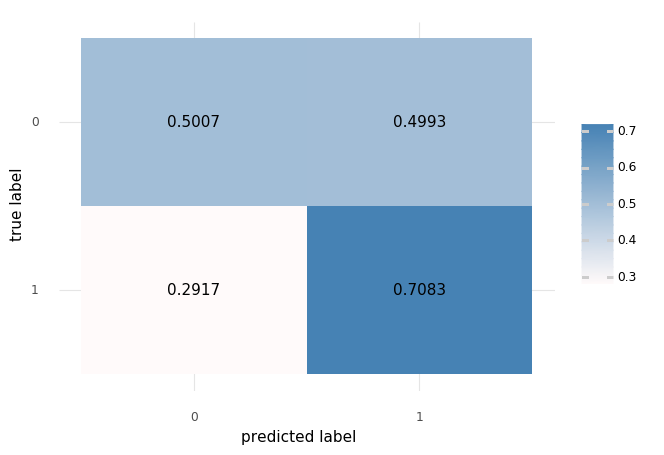

<ggplot: (302327756)>

In [53]:
pred = grid_logit.best_estimator_.predict(X_te)
cm = confusion_matrix(y_te, pred)
plot_confusion_matrix(cm, normalize=True)

## Part II: Gradient Boosting Classifier

In [54]:
%%time
params = { 
    'n_estimators': [100, 200],
    'subsample': [1],
    'max_depth' : [2, 4, 6, 8],
    'min_samples_split': [20],
    'min_samples_leaf': [20]
}

gbc = GradientBoostingClassifier()
gscv = GridSearchCV(gbc, params, cv=5, refit=True, return_train_score=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    gscv.fit(X_tr, y_tr)

CPU times: user 40 s, sys: 95.3 ms, total: 40 s
Wall time: 40.2 s


In [55]:
print(gscv.best_estimator_)
cv_results = pd.DataFrame(gscv.cv_results_)
print('Train score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_train_score'].values[0])
print('Test score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_test_score'].values[0])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=20,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)
Train score: 0.6718715673334482
Test score: 0.6101658410510445


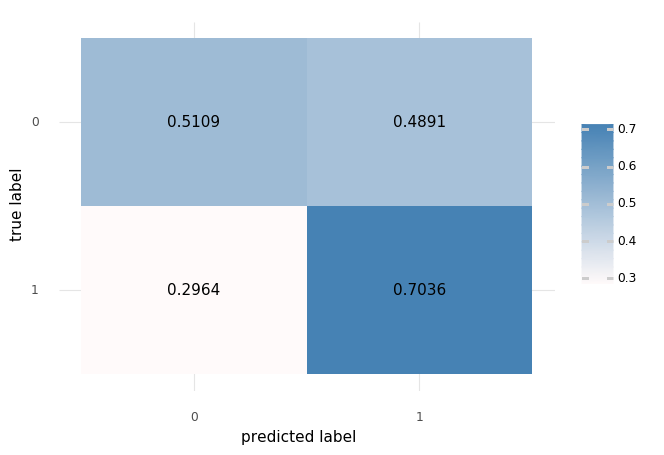

<ggplot: (303480875)>

In [56]:
pred = gscv.best_estimator_.predict(X_te)
cm = confusion_matrix(y_te, pred)
plot_confusion_matrix(cm, normalize=True)

# Presentation

## Plotting True vs. False   |  |  Positives vs. Negatives

In [57]:
df_log = pd.DataFrame({'True': [0.39405, 0.220284],
                    'False': [0.15956, 0.22609]},
                    index=['Positive','Negative'])

Text(0, 0.5, 'Percent (decimal)')

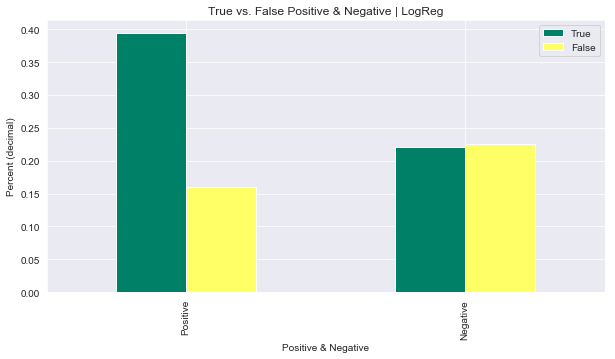

In [59]:
df_log.plot(kind='bar',figsize=(10,5),colormap='summer')
plt.title('True vs. False Positive & Negative | LogReg')
plt.xlabel('Positive & Negative')
plt.ylabel('Percent (decimal)')

In [43]:
df_gscv = pd.DataFrame({'True': [0.3908268, 0.22351],
                    'False': [0.16279, 0.222868]},
                    index=['Positive','Negative'])

Text(0, 0.5, 'Percent')

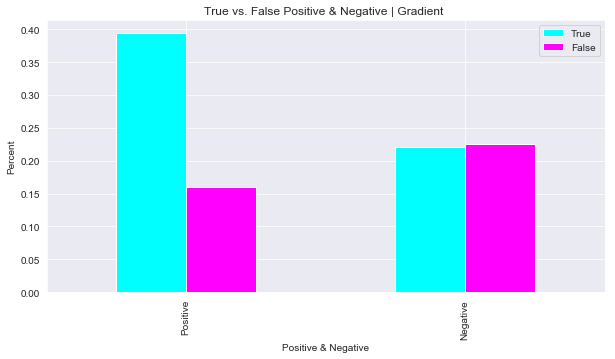

In [44]:
df_log.plot(kind='bar',figsize=(10,5),colormap='cool')
plt.title('True vs. False Positive & Negative | Gradient ')
plt.xlabel('Positive & Negative')
plt.ylabel('Percent')

## Build a Decision Tree

In [70]:
clf_nhl = DecisionTreeClassifier(criterion='gini',max_depth=3)
clf_nhl.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

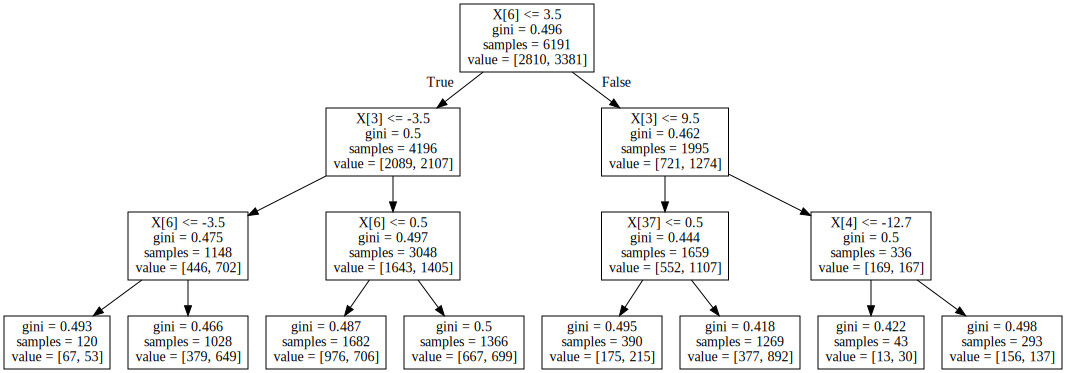

In [71]:
export_graphviz(clf_nhl, out_file="mytree.dot")
with open("mytree.dot") as f: dot_graph = f.read()
graphviz.Source(dot_graph)

## Impact by Variable

In [68]:
df_eff = pd.DataFrame(list(zip(
    X.columns,gscv.best_estimator_
    .feature_importances_))).sort_values(1,ascending=False)

In [69]:
df_eff

,0,1
6,takeaways_diff,0.215929
3,hits_diff,0.203837
5,giveaways_diff,0.104522
1,pim_diff,0.103212
37,settled_in_home_REG,0.076284
4,faceOffWinPercentage_diff,0.048831
2,shots_diff,0.044966
32,teamName_home_Sabres,0.027045
0,powerPlayOpportunities_diff,0.021227
38,settled_in_home_SO,0.019519


Text(0, 0.5, 'Impact')

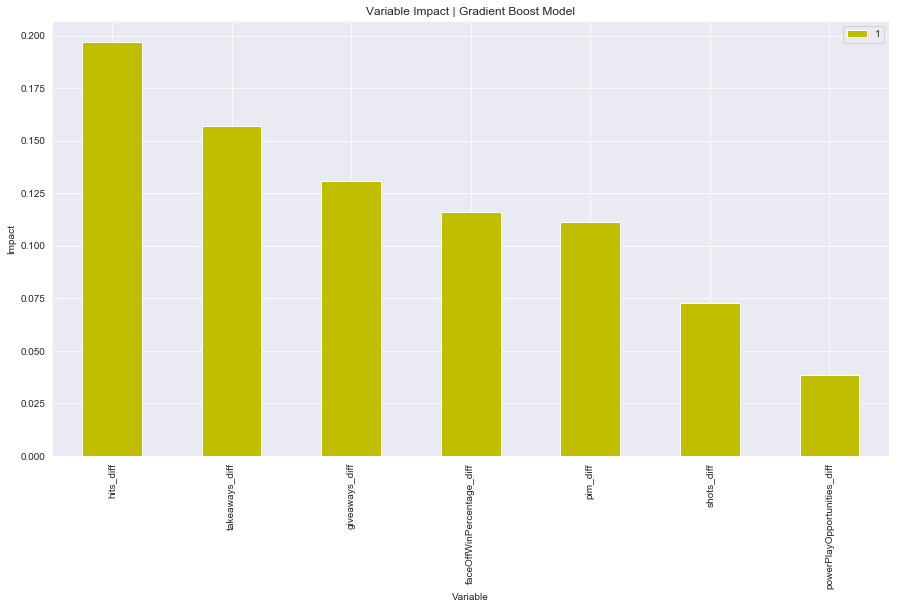

In [47]:
df_eff.head(7).plot(x=0,kind='bar',figsize=(15,8), color=['y'])
plt.title('Variable Impact | Gradient Boost Model')
plt.xlabel('Variable')
plt.ylabel('Impact')

<img src="final_project_rubric.png">

In [ ]:
print('Logistic Regression')
print('True Positive:',610/(247+610+341+350))
print('False Positive:',247/(247+610+341+350))
print('True Negative:', 341/(247+610+341+350))
print('False Negative:',350/(247+610+341+350))

print('='*50)

print('Gradient Boost Classifier')
print('True Positive:',605/(247+610+341+350))
print('False Positive:',252/(247+610+341+350))
print('True Negative:', 346/(247+610+341+350))
print('False Negative:',345/(247+610+341+350))

## Extra Work

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV

X = df[['powerPlayOpportunities_home','pim_home','shots_home',
            'hits_home','faceOffWinPercentage_home', 'giveaways_home', 'takeaways_home' ]]
y = df['goals_home']

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Measure performance - overall performance & correlation between our model & data
linreg = LinearRegression() # Initialize a regression object
linreg.fit(X_train, y_train) # Fit the model
y_linreg_train = linreg.predict(X_train)
y_linreg_test = linreg.predict(X_test)
train_mse = np.sqrt(mean_squared_error(y_train, y_linreg_train))
test_mse = np.sqrt(mean_squared_error(y_test, y_linreg_test))


# LassoCV Regression
L1 = LassoCV(normalize = True)
L1.fit(X_train, y_train)

print('Lasso Regression - performance')
print('Training r^2:', L1.score(X_train, y_train))
print('Testing r^2:', L1.score(X_test, y_test))
print('Training MSE:', np.sqrt(mean_squared_error(y_train, L1.predict(X_train))))
print('Testing MSE:', np.sqrt(mean_squared_error(y_test, L1.predict(X_test))))
print('Best alpha:', L1.alpha_)
print(' ')

print('Linear Regression - Model Coefficients')
print('Training R^2 model score:', linreg.score(X_train,y_train))
print('Testing R^2 model score:', linreg.score(X_test,y_test))
print('Training MSE:', train_mse)
print('Testing MSE:', test_mse)
print(' ')

In [ ]:
df['Estimated_Home_Goals_Lasso'] = L1.predict(X)
df['residual_LinReg'] = df['Estimated_Home_Goals_Lasso'] - df['home_goals']

In [ ]:
X = df[['powerPlayOpportunities_away','pim_away','shots_away',
            'hits_away','faceOffWinPercentage_away','giveaways_away','takeaways_away']]
y = df['goals_away']

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Measure performance - overall performance & correlation between our model & data
linreg2 = LinearRegression() # Initialize a regression object
linreg2.fit(X_train, y_train) # Fit the model
y_linreg2_train = linreg.predict(X_train)
y_linreg2_test = linreg.predict(X_test)
train2_mse = np.sqrt(mean_squared_error(y_train, y_linreg2_train))
test2_mse = np.sqrt(mean_squared_error(y_test, y_linreg2_test))


# LassoCV Regression
L2 = LassoCV(normalize = True)
L2.fit(X_train, y_train)

print('Lasso Regression - performance')
print('Training r^2:', L2.score(X_train, y_train))
print('Testing r^2:', L2.score(X_test, y_test))
print('Training MSE:', np.sqrt(mean_squared_error(y_train, L2.predict(X_train))))
print('Testing MSE:', np.sqrt(mean_squared_error(y_test, L2.predict(X_test))))
print('Best alpha:', L2.alpha_)
print(' ')

print('Linear Regression - Model Coefficients')
print('Training R^2 model score:', linreg2.score(X_train,y_train))
print('Testing R^2 model score:', linreg2.score(X_test,y_test))
print('Training MSE:', train_mse)
print('Testing MSE:', test_mse)
print(' ')

In [ ]:
df['Estimated_Away_Goals_Lasso'] = L2.predict(X)
df['residual_LinReg'] = df['Estimated_Away_Goals_Lasso'] - df['away_goals']

In [ ]:

(
ggplot(df, aes(x='home_goals', y='Estimated_Home_Goals_Lasso', fill='home_goals')
      )
 + geom_point(stat='identity')
#  + geom_smooth(method='lm')
 + theme_minimal() 
 + aes(color='residual_LinReg')
#  + coord_flip()
#  + coord_fixed()
#  + scale_size_continuous(range = (2,4)) 
    + xlim(-5000, 150000)
    + ylim(-5000, 150000)
)



# ggplot(data,aes(x.plot,y.plot))+stat_summary(fun.data=mean_cl_normal) + 
#   geom_smooth(method='lm',formula=y~x)
# x , y = df.Year, df.Weekly_Sales.sum()
# # print(np.corrcoef(x,y))
# plt.bar(x,y)